# Майнор Интеллектуальный анализ данных / Введение в анализ данных

## Домашнее задание 3. Логистическая регрессия и случайный лес.

В этом задании вам предстоит:
- поработать с логистической регрессией (полная реализация не потребуется, однако можно заработать бонусные баллы)
- воспроизвести подход случайного леса через одно решающее дерево, поэкспериментировать со случайным лесом.

На все вопросы требуется отвечать развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.
- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.04.2018
- Срок сдачи: 23:59 18.05.2018

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Подготовка данных.

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.

Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [4]:
train['class'] = 0 + 1*(train['price_range']>1) # задаем значение "0" для классов 0/1 и "1" для остальных

del train['price_range'] #удаляем старую колонку
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,class
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,1
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,1
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,1
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,0


Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [91]:
from sklearn.model_selection import train_test_split as tts

#разделяем в отношении 7 к 3
data_train, data_test = tts(train, train_size = 0.7, test_size = 0.3, random_state=3).copy() 

X_train = data_train.iloc[:,:-1].copy()
y_train = data_train.iloc[:,-1].copy()
X_test = data_test.iloc[:,:-1].copy()
y_test = data_test.iloc[:,-1].copy()

## Часть 1. Логистическая регрессия.

[4 балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [92]:
#нормируем признаки для получения единого масштаба

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?

Не забывайте, что метод `predict_proba` вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 

LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict_proba(X_test)[:,1] #выбираем колонку, отвечающую за принадлежность к положительному классу

AUC_ROC = metrics.roc_auc_score(y_test, y_pred)
print('AUC-ROC: ', str(AUC_ROC))

acc = metrics.accuracy_score(y_test, y_pred>0.5) #значения вероятности больше 0.5 относим к "1", меньше - к "0"
print('Accuracy:', str(acc))

AUC-ROC:  0.999744399004
Accuracy: 0.991666666667


    Качество предсказания целевой переменной высокое

У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

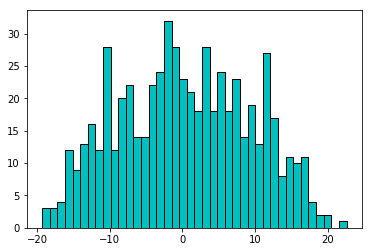

In [94]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#фиксируем коэффициенты
w = LR.coef_
w0 = LR.intercept_

#рассчитываем значения по формуле логистической регрессии
y_raw = np.dot(X_test, w.reshape(-1)) + w0

plt.hist(y_raw, 40,  color='c', normed = False, edgecolor = 'black')
plt.show()

    Результат принимает значения в интервале [-20;20]. Вероятности лежат в интервале [0;1], т.е. полученные значения вероятностями не являются.
    

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

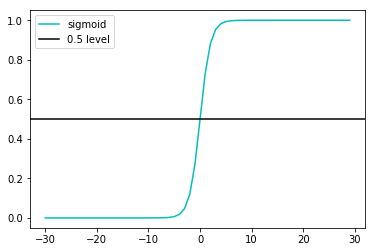

In [95]:
def Sigmoid(arr):        
    arr = np.array(sorted(arr)) # сортируем данные для корректного построения функции
    sigm = 1/(1+exp(-arr))
    plt.plot(arr,sigm, 'c', label = 'sigmoid')
    plt.axhline(0.5, color = 'black', label = '0.5 level') # задаем уровень в 0.5
    plt.legend()
    plt.show()
    
Sigmoid(np.arange(-30,30))

   Сигмоида - гладкая монотонная непрерывная функция, стремящаяся к 0 на -∞ и к 1 на +∞. В нуле принимает значение 0.5. 

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

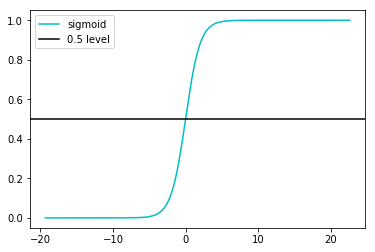

Proportion of correct answers: 1.0


In [96]:
res = Sigmoid(y_raw)

print("Proportion of correct answers: "+str((res == y_pred).size/y_pred.size)) # доля совпавших ответов

Значения совпали на 100%


Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

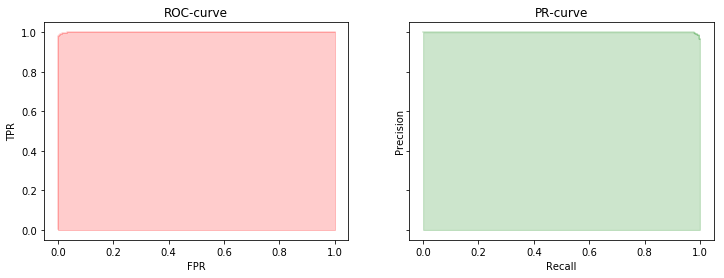

In [97]:
#фиксируем значения для построения графиков метрик
fpr, tpr, thresholds1 = metrics.roc_curve(y_test, y_pred)
prec, rec, thresholds2 = metrics.precision_recall_curve(y_test, y_pred)

fig, ax= plt.subplots(1,2, figsize=(12,4), sharey = 'row', sharex='row')
ax[0].step(fpr,tpr, color = 'r',alpha=0.2, where='post')
ax[0].fill_between(fpr, tpr, step='post', alpha=0.2, color = 'r')
ax[0].set_title('ROC-curve')
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')

ax[1].step(rec,prec, color = 'g',alpha=0.2, where='post')
ax[1].fill_between(rec, prec, step='post', alpha=0.2, color = 'g')
ax[1].set_title('PR-curve')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

plt.show()

### Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В `loss_history` необходимо сохранять вычисленное на каждой итерации значение функции потерь. 

In [75]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        
        pass
        
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        pass
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        pass
        

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        pass

1. Примените логистическую регресиию на той же выборке.
2. Посчитайте качество по тем же метрикам.
3. Визуализируйте изменение значений функции потерь от номера итераций.

## Часть 2. Случайные леса.

[6 баллов]

Случайный лес — алгоритм машинного обучения, представляющий собой бэггинг над решающими деревьями (усреднение ответов множества слабых алгоритмов) с 2 основными идеями:
- Использование подмножества признаков при построении каждого сплита дерева.
- Бутстрап обучающей выборки для построения каждого дерева (с повторениями).

В этом задании мы попробуем оценить пользу каждой из идей. Будем использовать ту же выборку с тем же разбиением на 2 части. Для начала обучите решающее дерево `DecisionTreeClassifier` из scikit-learn и посчитайте ROC-AUC и Accuracy (порог 0.5). Не забудьте зафикиксировать сид для построения дерева (несмотря на то, что в классической реализации никакой случайности нет, при большой глубине дерева может возникать неоднозначность в выборке признака в сплите). Используйте этот сид для всех заданий ниже.

In [99]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(random_state=123) # фиксируем единый сид для всех заданий
DTC.fit(X_train, y_train)
y_pred = DTC.predict_proba(X_test)[:,1]

AUC_ROC = metrics.roc_auc_score(y_test, y_pred)
print('AUC-ROC: ', str(AUC_ROC))

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Accuracy:', str(acc))

AUC-ROC:  0.939989331437
Accuracy: 0.94


### 2.1 Бэггинг классификаторов

Реализуйте бэггинг над решающими деревьями (усреднение предсказанных вероятностей всего ансамбля). 
В качестве основы используйте всё тот же `DecisionTreeClassifier`. Количество базовых алгоритмов предлагается брать равным 100. 

Посчитайте качество с помощью тех же метрик. Ответьте на следующие вопросы:
- Что интересного вы видите?
- С чем это связано?

In [100]:
np.random.seed(123)

"""
x_train, y_train, x_test, y_test - выборки для обучения и тестирования
trees_amount - количество решающих деревьев
repeats - булевая переменная, наличие повторений при выборе рандомных чисел
"""

def Bagging(x_train, y_train, x_test, y_test, trees_amount, repeats):
    trees = np.zeros(x_test.shape[0]) #задаем пустую матрицу для сохранения значений
    c = x_train.shape[0] #количество объектов в обучающей выборке
    y_reind = array(y_train) #копируем вектор ответов, чтобы индексы шли по порядку с 0
    
    DTC = DecisionTreeClassifier()

    for i in range(trees_amount):       
        nums = np.random.choice(c, c, replace=repeats)
        DTC.fit(x_train[nums], y_reind[nums])
        trees += (DTC.predict_proba(x_test)[:,1]) #записываем результаты в матрицу

    trees/=trees_amount #усредняем значения в матрице, получаем вероятности в интервале [0;1]

    AUC_ROC = metrics.roc_auc_score(y_test, trees)
    print('AUC-ROC: ', str(AUC_ROC))

    acc = metrics.accuracy_score(y_test, trees>0.5)
    print('Accuracy:', str(acc))
    
Bagging(X_train, y_train, X_test, y_test, 100, False) #вызов функции для бэггинга без бутстрапа

AUC-ROC:  0.950052231508
Accuracy: 0.946666666667


Качество алгоритма повысилось для обеих метрик. Это достигается с помощью усреднения результатов по большому количеству случайных деревьев.

### 2.2 Сэмплирование обучающей выборки

Добавим к нашему бэггингу бутстрап выборки (генерация случайной выборки того же размера с возвращением). Для этого может пригодиться `numpy.random.randint`.

Посчитайте качество. Что вы видите?

In [101]:
np.random.seed(123)  # для одинакового бутстрапа в каждом запуске

Bagging(X_train, y_train, X_test, y_test, 100, True) #вызов функции для бэггинга бутстрапом


AUC-ROC:  0.995193589972
Accuracy: 0.958333333333


При бутстрапе качество выросло, особенно для AUC-ROC. 

### 2.3 Выбор случайного подмножества признаков

Временно забудем о бутстрапе выборки и добавим выбор случайного подмножества признаков при построении каждого сплита. В `DecisionTreeClassifier` за это отвечает параметр `max_features`. По умолчанию он имеет значение `None`, что обозначает использование всех возможных признаков. Для задачи классификации рекоменуется использовать квадратный корень от количества признаков. Попробуйте выставить такое значение. На этот раз надо отключить фиксированный сид в построении дерева, так как иначе каждый раз мы будем выбирать одинаковые подмножества признаков. 

Посчитайте качество. Что вы видите?

In [102]:
np.random.seed(123)  # для воспроизводимости построения случайных подмножеств признаков

"""
x_train, y_train, x_test, y_test - выборки для обучения и тестирования
trees_amount - количество решающих деревьев
"""

def Features(x_train, y_train, x_test, y_test, trees_amount):
    trees = np.zeros(x_test.shape[0]) #задаем пустую матрицу для сохранения значений
    y_reind = array(y_train)
    
    DTC = DecisionTreeClassifier(max_features='sqrt') #фиксируем максимальное число признаков

    for i in range(trees_amount):       
        DTC.fit(x_train, y_reind)
        trees += (DTC.predict_proba(x_test)[:,1])

    trees/=trees_amount

    AUC_ROC = metrics.roc_auc_score(y_test, trees)
    print('AUC-ROC: ', str(AUC_ROC))

    acc = metrics.accuracy_score(y_test, trees>0.5)
    print('Accuracy:', str(acc))
    
Features(X_train, y_train, X_test, y_test, 100) #вызов функции для обучения на случайных подмножествах

AUC-ROC:  0.992809832859
Accuracy: 0.951666666667


Результаты оказались схожими с бутстрапом: значительно выше, чем обычный бэггинг. Достигается это снова усреднением ответов по множеству решающих деревьев.  

### 2.4 = 2.2 + 2.3

Объединим два подхода (бутстрап + выбор подмножества признаков). Получим случайный лес.

Посчитайте качество. Что вы видите?

In [103]:
np.random.seed(123)  # для одинакового бутстрапа и выбора подмножеств признаков в каждом запуске

"""
x_train, y_train, x_test, y_test - выборки для обучения и тестирования
trees_amount - количество решающих деревьев
repeats - булевая переменная, наличие повторений при выборе рандомных чисел
"""

def RanFor(x_train, y_train, x_test, y_test, trees_amount, repeats):
    trees = np.zeros(x_test.shape[0])
       
    objs = x_train.shape[0] # число объектов   
    y_reind = array(y_train)
    
    DTC = DecisionTreeClassifier(max_features='sqrt')
    
    for i in range(trees_amount):       
        objs_nums = np.random.choice(objs, objs, replace=repeats) #случайные индексы для выбора объектов
        DTC.fit(x_train[objs_nums], y_reind[objs_nums])
        trees += (DTC.predict_proba(x_test)[:,1])

    trees/=trees_amount
    
    AUC_ROC = metrics.roc_auc_score(y_test, trees)
    print('AUC-ROC: ', str(AUC_ROC))

    acc = metrics.accuracy_score(y_test, trees>0.5)
    print('Accuracy:', str(acc))
    
# вызов функции для обучения на случайных подмножествах с бутстрапом (случайный лес)    
RanFor(X_train, y_train, X_test, y_test, 100, True) 

AUC-ROC:  0.992632023471
Accuracy: 0.948333333333


Качество accuracy незначительно уменшилось, AUC-ROC остался приблизительно таким же.

То, что мы сделали уже реализовано в `RandomForestClassifier`. Попробуйте воспользоваться им. Количество используемых деревьев передаётся в параметре `n_estimators`.

Посчитайте качество. Что вы видите?

In [104]:
np.random.seed(123)

from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators = 100) #случайный лес со 100 деревьями
RFC.fit(X_train, y_train)
y_pred = RFC.predict_proba(X_test)[:,1]

AUC_ROC = metrics.roc_auc_score(y_test, y_pred)
print('AUC-ROC: ', str(AUC_ROC))

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Accuracy:', str(acc))

AUC-ROC:  0.992737597795
Accuracy: 0.953333333333


Качество для RandomForestClassifier оказалось приблизительно таким же, как и для случайного леса, реализованного вручную.

### 2.5 Влияние количества используемых деревьев в случайном лесе

Один из параметров случайного леса — количество деревьев, используемых в бэггинге. Оценим, как влияет этот параметр на финальное качество. Для этого обучите случайные леса с разным количество деревьев (например, перебирайте от 10 до 1000 с шагом в 10), оцените качество с помощью ROC-AUC. Постройте график зависимости ROC-AUC от количества используемых деревьев. Что вы видите?

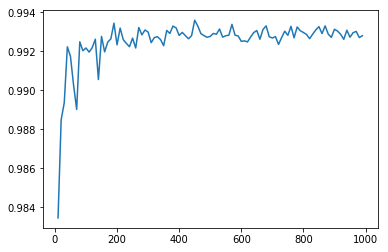

In [57]:
nums = np.arange(10,1000,10) #список значений для n_estimators
aucs = [] #список значений AUC-ROC

for n in nums:
    RFC = RandomForestClassifier(n_estimators = n)
    RFC.fit(X_train, y_train)
    y_pred = RFC.predict_proba(X_test)[:,1]
    AUC_ROC = metrics.roc_auc_score(y_test, y_pred)
    aucs.append(AUC_ROC) #заполняем список значений AUC-ROC
    
plt.plot(nums, aucs)
plt.show()


Качество резко возрастает при увеличении числа деревьев до 100, после 150-200 результаты приблизительно одинаковые.

### 2.6 Важность признаков

Случайный лес позволяет оценить важность признаков. У обученного случайного леса есть аттрибут `feature_importances_`, где храниться важность для каждого признака. Постройте `barplot` с важностью признаков (удобно использовать библиотеку `seaborn`, где можно для каждого столбца передать название признака `train.columns`).

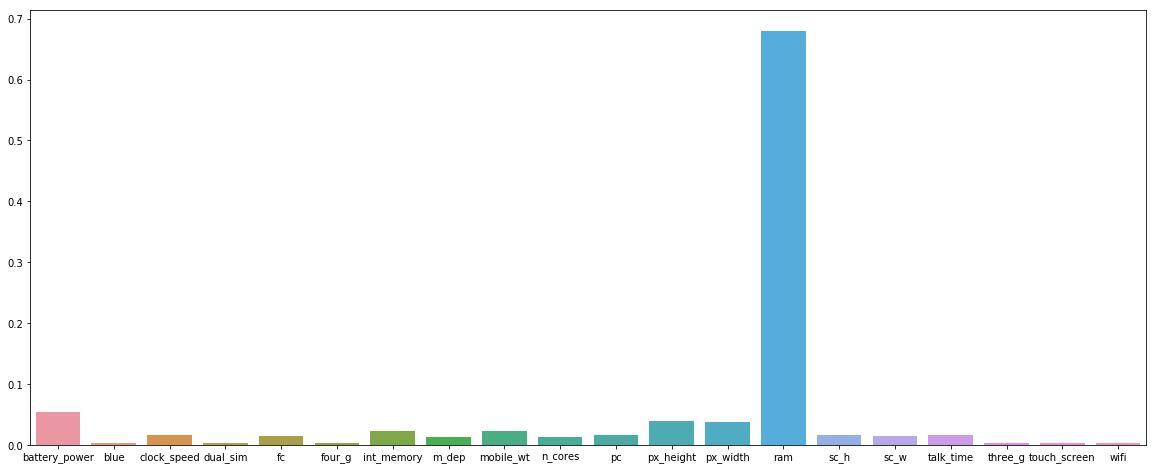

In [58]:
import seaborn

#изменяем размер графика, чтобы сделать подписи различимыми
from pylab import rcParams
rcParams['figure.figsize'] = 20,8

RFC = RandomForestClassifier(n_estimators = 100)
RFC.fit(X_train, y_train)

#фиксируем важность признаков
imp = RFC.feature_importances_
seaborn.barplot(train.columns[:-1], imp)

Наибольшее влияние на ценовую категорию телефона оказывает объем оперативной памяти.

## Выводы

Напишите, что интересного вы узнали в этой работе, в каких экспериментах какие результаты получились.

- В данной работе мне удалось поработать с логистической регрессией, решающими деревьями, бэггингом, бутстрапом, случайными лесами. Для проведения экспериментов был выбран датасет, отражающий зависимость ценовой категории мобильного устройства от 20-ти его характеристик.

- Логистическая регрессия показала высокие результаты на отложенной выборке. Значения accuracy и AUC-ROC оказались близкими к единице. 

- Одно отдельное случайное дерево дает значительно более низкие результаты: метрики качества показали значения порядка 0.93-0.94.

- Бэггинг без бутстрапа (без повторений) незначительно повышает качество модели благодаря усреднению значений для большого числа деревьев. 

- Бэггинг с бутстрапом позволил значительно повысить значение AUC-ROC (почти 1) и accuracy (около 0.96). 

- Выбор подмножества признаков так же дал высокие результаты, однако немного ниже, чем бутстрап. Это связано с тем, что значение одного признака (RAM) оказывает в разы более сильное влияние на итоговый результат в сравнении с остальными 19. Если в решающее дерево не попадает данный признак, то качество модели снижается, что существенно сказывается на усредненных значениях.

- Случайный лес, реализованный вручную, дал результаты, схожие с обучением по подмножеству признаков.

- RandomForestClassifier также показал высокие результаты, однако все равно более низкие, чем бутстрап.

- Таким образом, наиболее точные результаты для рассматриваемого датасета показали логистическая регрессия и бутстрап. Преимущество бутстрапа над остальными способами обучения на решающих деревьев в данном случае связано с распределением важности признаков: существует явно доминирующая характеристика (RAM), поэтому перебор признаков не дает таких высоких результатов.